In [63]:
# Set up Notebook
% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [64]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
labels = ['clust_logFCS', 'clust_RCSI', 'clust_HDDS']

In [65]:
X = train_data.drop(labels, axis=1)
x_train=train_data.drop(labels, axis=1)
x_train = x_train.drop(x_train.columns[0], axis=1)
x_test=test_data.drop(labels, axis=1)
x_test = x_test.drop(x_test.columns[0], axis=1)

x_train.head()

,clust_L12raincytot,clust_L12day1rain,clust_L12maxdays,clust_floodmax,clust_cells_own,clust_price,clust_thinn,clust_roof,clust_hhsize,clust_hh_age,clust_hh_gender,clust_asset,clust_dist_road,clust_dist_admarc,clust_percent_ag,clust_nutri_reten_constrained,clust_elevation,ipc_lag1,ipc_lag12
0,1090.06130,43,17,0.0,0.1250,3.824215,0.359375,0.1250,5.4375,41.6250,1.2500,-0.327686,1.395625,5.176875,0.6000,0.0000,1311.8750,1.0,NaN
1,855.86176,58,40,0.0,0.4375,3.917409,0.250000,0.1875,5.6875,36.5625,1.3125,-0.202549,0.756875,5.408750,0.6000,0.9375,496.0000,1.0,NaN
2,1300.24370,53,29,0.0,1.5000,3.683867,0.250000,0.5000,6.3750,40.4375,1.3750,0.548275,0.163125,17.038126,0.4500,1.0000,526.7500,1.0,NaN
3,1036.97120,52,29,0.0,0.6250,4.061391,0.500000,0.2500,5.4375,46.8750,1.1875,-0.077412,5.803750,7.724375,0.4375,0.0000,564.1875,1.0,NaN
4,952.18280,54,25,0.0,0.5625,3.879500,0.250000,0.0625,7.0000,43.8125,1.0000,-0.202549,11.286875,11.103125,0.4875,1.0000,1539.9375,1.0,NaN


In [66]:
y_train = train_data[labels]
y_test = test_data[labels]
y_test.head()

,clust_logFCS,clust_RCSI,clust_HDDS
0,3.666015,12.312500,4.687500
1,3.718879,5.352941,5.235294
2,3.799830,5.080000,5.720000
3,3.844891,4.285714,5.095238
4,3.687936,0.812500,5.312500


In [67]:

# y_test = math.log(y_test)

In [68]:
from sklearn.preprocessing import Imputer,StandardScaler

imp = Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
x_train = imp.fit_transform(x_train)
x_test = imp.fit_transform(x_test)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)


In [69]:
y_train["clust_RCSI"] = np.arcsinh(y_train["clust_RCSI"])
y_test["clust_RCSI"] = np.arcsinh(y_test["clust_RCSI"])


In [70]:
y_test.head()


,clust_logFCS,clust_RCSI,clust_HDDS
0,3.666015,3.205407,4.687500
1,3.718879,2.379406,5.235294
2,3.799830,2.328008,5.720000
3,3.844891,2.161776,5.095238
4,3.687936,0.742399,5.312500


(array([ 45.,  52.,  62.,  97., 126., 128., 118.,  74.,  51.,  15.]),
 array([0.        , 0.35417984, 0.70835969, 1.06253953, 1.41671937,
        1.77089921, 2.12507906, 2.4792589 , 2.83343874, 3.18761858,
        3.54179843]),
 <a list of 10 Patch objects>)

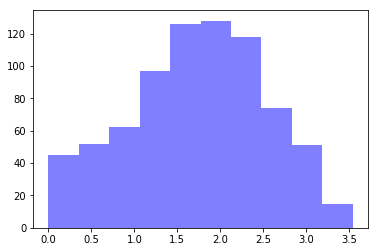

In [71]:
import matplotlib.pyplot as plt
plt.hist(y_train["clust_RCSI"] , 10, facecolor='blue', alpha=0.5)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
x_train = poly.fit_transform(x_train)
x_test =  poly.fit_transform(x_test)

import numpy as np
y_train["clust_RCSI"] = np.arcsinh(np.array (y_train[labels[1]])) 
y_test["clust_RCSI"] = np.arcsinh(np.array (y_test[labels[1]])) 

In [72]:
from sklearn.linear_model import LinearRegression

# Create and fit our linear regression model to training data
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train["clust_RCSI"])

# Compute model predictions for test data
pred = model.predict(x_test)
actual = y_test["clust_RCSI"]

r2_linear = stats.pearsonr(actual, pred)[0] ** 2
r2_linear


0.12297431987562665

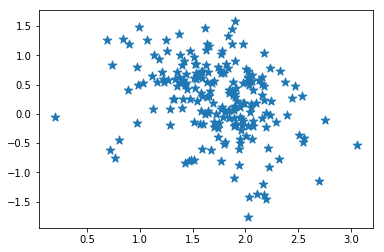

In [73]:
import matplotlib.pyplot as plt
plt.scatter(pred, actual-pred, s=80,marker="*")

In [80]:
# fit on logFCS 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create Regressor with default properties
rfc = RandomForestRegressor(random_state =0,n_jobs =4,warm_start = True)
parameters = {'max_depth':np.arange( 10,30, 1 ).tolist(), 'min_samples_leaf':np.arange( 5, 10, 1 ).tolist()}
clf = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')
clf.fit(x_train, y_train[labels[1]])
 
# Regress on test data
pred = clf.predict(x_test)

actual =  y_test[labels[1]]
r2_rfc = stats.pearsonr(actual, pred)[0] ** 2
r2_rfc

0.025886062560550326

In [81]:
clf.best_params_

{'max_depth': 10, 'min_samples_leaf': 6}

In [79]:
from sklearn.gaussian_process import  GaussianProcessRegressor

# Import our kernels
from sklearn.gaussian_process.kernels import Matern, WhiteKernel



# Define custom kernel (Matern + noise)
krnl = 2. + Matern(length_scale=1, nu=1.3) + WhiteKernel(noise_level=10)

# Create Regressor with specified properties
gpr = GaussianProcessRegressor(kernel=krnl, random_state=23)

# Fit estimator and display score
gpr= gpr.fit(x_train, y_train["clust_RCSI"])
pred = gpr.predict(x_test)
actual = y_test["clust_RCSI"]
r2_gpr= stats.pearsonr(actual, pred)[0] ** 2
r2_gpr



0.1235376781169247

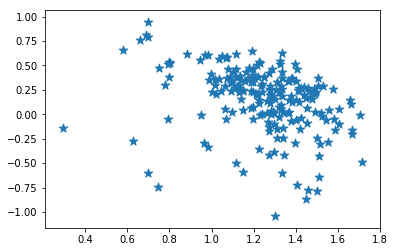

In [32]:
plt.scatter(pred, actual-pred, s=80,marker="*")

In [54]:

from sklearn.linear_model import Ridge

# Define different alpha values for different fits
alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

ridge = Ridge(alpha=20,fit_intercept=False)

ridge.fit(x_train, y_train["clust_RCSI"])
pred = ridge.predict(x_test)

actual = y_test["clust_RCSI"]
r2_ridge= stats.pearsonr(actual, pred)[0] ** 2
r2_ridge

0.0926673655785274

In [49]:
from sklearn.linear_model import BayesianRidge
bridge = BayesianRidge(compute_score=True)
bridge.fit(x_train, y_train["clust_RCSI"])
pred = bridge.predict(x_test)

actual = y_test["clust_RCSI"]
r2_bridge= stats.pearsonr(actual, pred)[0] ** 2
r2_bridge

0.12311634209636571

In [44]:
from sklearn.linear_model import Lasso
alpha = [1E-4, 1E-2, 0.1, 1.0]

ls = Lasso(alpha=alpha[2], fit_intercept=True)


ls = ls.fit(x_train, y_train["clust_RCSI"])
pred = ls.predict(x_test)

actual = y_test["clust_RCSI"]
r2_ls= stats.pearsonr(actual, pred)[0] ** 2
r2_ls

0.24835244248878724

In [52]:
lasso_zip  = zip(X.columns[1:], ls.coef_)
import operator

for count,ele in enumerate(sorted(lasso_zip,key=operator.itemgetter(1),reverse=False)): 
    print (count,ele)

0 ('clust_cells_own', -0.019282583172118062)
1 ('clust_L12raincytot', -0.0)
2 ('clust_L12day1rain', 0.0)
3 ('clust_L12maxdays', -0.0)
4 ('clust_floodmax', 0.0)
5 ('clust_price', 0.0)
6 ('clust_thinn', 0.0)
7 ('clust_roof', -0.0)
8 ('clust_hhsize', 0.0)
9 ('clust_hh_age', 0.0)
10 ('clust_hh_gender', 0.0)
11 ('clust_asset', -0.0)
12 ('clust_dist_road', 0.0)
13 ('clust_dist_admarc', 0.0)
14 ('clust_percent_ag', 0.0)
15 ('clust_nutri_reten_constrained', -0.0)
16 ('clust_elevation', -0.0)
17 ('ipc_lag1', 0.0)
18 ('ipc_lag12', 0.0)


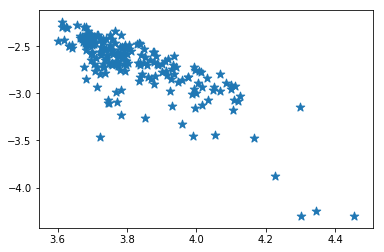

In [46]:
plt.scatter(pred, actual-pred, s=80,marker="*")

(array([ 27.,   8.,  27.,  26.,  38.,  51.,  99., 156., 223., 113.]),
 array([0.        , 0.14333654, 0.28667308, 0.43000961, 0.57334615,
        0.71668269, 0.86001923, 1.00335576, 1.1466923 , 1.29002884,
        1.43336538]),
 <a list of 10 Patch objects>)

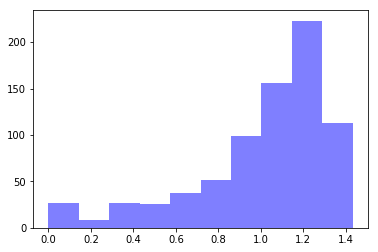

In [47]:
plt.hist(y_train["clust_RCSI"] , 10, facecolor='blue', alpha=0.5)

In [45]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

alpha = [1E-4, 1E-2, 0.1, 1.0]


en = ElasticNet()

parameters = {'l1_ratio':np.arange( 0.1, 0.4, 0.05 ).tolist(), 'alpha':np.arange( 0.1, 0.3, 0.05 ).tolist()}
clf = GridSearchCV(en, parameters,cv=5, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')
clf.fit(x_train, y_train[labels[0]])

pred = clf.predict(x_test)

actual = y_test["clust_RCSI"]
r2_en= stats.pearsonr(actual, pred)[0] ** 2
r2_en


0.19468275681439867

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor with default properties
gbr = GradientBoostingRegressor(random_state=0)

gbr.fit(x_train, y_train["clust_RCSI"])
pred = gbr.predict(x_test)

actual = y_test["clust_RCSI"]
r2_gbr= stats.pearsonr(actual, pred)[0] ** 2
r2_gbr


0.07500623916052811